In [1]:
!wget https://dl3.pushbulletusercontent.com/uUN2AiPUxxvqfJlWaWhbhNQdZVrprSBu/code.zip
!unzip code.zip
!rm EC.py
!rm mnca.py

--2023-04-01 13:13:25--  https://dl3.pushbulletusercontent.com/uUN2AiPUxxvqfJlWaWhbhNQdZVrprSBu/code.zip
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4934 (4.8K) [application/x-zip-compressed]
Saving to: ‘code.zip’

code.zip            100%[===================>]   4.82K  --.-KB/s    in 0.002s  

2023-04-01 13:13:26 (2.28 MB/s) - ‘code.zip’ saved [4934/4934]

Archive:  code.zip
  inflating: EC.py                   
  inflating: mnca.py                 
  inflating: neighborhoods/mask_c1.txt  
  inflating: neighborhoods/mask_c2.txt  
  inflating: neighborhoods/mask_c3.txt  


In [2]:
rule = [[(0.451, 0.713, 0), (0.449, 0.663, 1), (0.191, 0.52, 1), (0.089, 0.296, 0)], [(0.332, 0.51, 0), (0.084, 0.307, 0), (0.182, 0.465, 1)], [(0.799, 0.902, 0), (0.303, 0.456, 0), (0.835, 0.984, 1)]]

# FOR EC - Results available here - https://github.com/s4nyam/emnca/blob/main/emnca/p10g50_1.ipynb



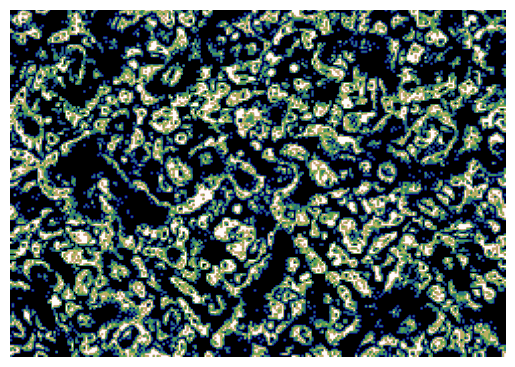

In [3]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np


import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D

def coarse_grain(input_grid):
    # Define the coarse-graining scale factor
    scale_factor = 2
    
    # Determine the size of the input grid
    n_rows, n_cols = input_grid.shape
    
    # Check that the input grid has an even number of rows and columns
    assert n_rows % 2 == 0 and n_cols % 2 == 0, "Input grid must have an even number of rows and columns"
    
    # Determine the size of the output grid
    out_n_rows, out_n_cols = n_rows // scale_factor, n_cols // scale_factor
    
    # Reshape the input grid to a 4D tensor for use with a CNN
    input_tensor = input_grid.reshape((1, n_rows, n_cols, 1))
    
    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(filters=1, kernel_size=scale_factor, strides=scale_factor, padding='valid', activation='linear', input_shape=(n_rows, n_cols, 1)))
    
    # Set the weights of the CNN to perform averaging
    weights = np.ones((scale_factor, scale_factor, 1, 1)) / (scale_factor ** 2)
    model.set_weights([weights, np.zeros(1)])
    
    # Apply the CNN to the input tensor to produce the output tensor
    output_tensor = model.predict(input_tensor,verbose=0)
    
    # Reshape the output tensor to a 2D array
    output_grid = output_tensor.reshape((out_n_rows, out_n_cols))
    
    return output_grid





def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = 0.250 # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.250 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board

new_frames = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]
                
                # # use this for sum
                # neighborhood_sum = sum(cell_neighborhood)
                
                # use this for average
                neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    board = coarse_grain(board) # Adding coarse grained
    new_frames.append(board)
    img.set_data(board)
    return img,

def run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums):
    board = init_board(width, height, init_state)
    fig, ax = plt.subplots()
    plt.axis('off')
    img = ax.imshow(board, cmap='binary')
    ani = animation.FuncAnimation(fig, update, frames=steps, fargs=(img, board, neighborhoods, range_of_neighborhood_sums), repeat=False)
    # ani.save(filename, dpi=80, writer='imagemagick')
    ani.save(filename, dpi=200, writer='ffmpeg', codec='h264')

def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood


width = 500
height = 350
steps = 100
init_state = "random cells with some probability"




nh1 = extract_neighborhood_from_file('neighborhoods/mask_c1.txt')
nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')
neighborhoods = [nh1,nh2,nh3]
range_of_neighborhood_sums=rule



filename = "cellular_automatonf2_"+str(range_of_neighborhood_sums)[0:16]+".mp4"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)




In [4]:
# new frames and new anomation

def check_long_standing_cells(frames, min_steps=10, dead_steps=8):
    # Initialize a counter for each cell to keep track of how long it has stayed in the same state
    cell_counters = np.zeros_like(frames[0], dtype=int)
    
    # Iterate through the frames and update the cell counters
    for frame in frames:
        for i in range(frame.shape[0]):
            for j in range(frame.shape[1]):
                if frame[i,j] == 0:
                    cell_counters[i,j] = 0
                else:
                    cell_counters[i,j] += 1
    
    # Iterate through the cell counters and set cells that have stayed in the same state for at least min_steps to 0
    for i in range(cell_counters.shape[0]):
        for j in range(cell_counters.shape[1]):
            if cell_counters[i,j] >= min_steps:
                frames[0][i,j] = 0
                for k in range(1, dead_steps):
                    frames[k][i,j] = 0
    
    return frames

new_animation_data = check_long_standing_cells(new_frames) # new frames
# print(new_animation_data)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def create_animation(frames_list, filename):
    """
    Creates a GIF animation from a list of frames using matplotlib.

    Parameters:
    frames_list (list of numpy arrays): A list of frames represented as numpy arrays.
    filename (str): The name of the output GIF file.

    Returns:
    None
    """
    fig, ax = plt.subplots()
    im = ax.imshow(frames_list[0],cmap="binary")

    def update(frame):
        im.set_data(frame)
        return [im]

    ani = FuncAnimation(fig, update, frames=frames_list, blit=True)
    ani.save(filename, writer='pillow')


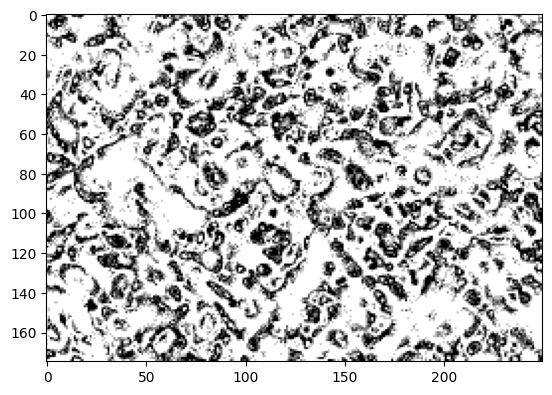

In [6]:
frames_list = new_animation_data
filename = "animation.gif"
create_animation(frames_list, filename)
